In [1]:
from datetime import datetime
import pickle

import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm import tqdm

## 预处理
除去标题行：27740895 rows x 6 columns
- **transit_timestamp**: from *2022/2/1* to *2024/1/13*, 1 hour interval
- **bus_route**: B1 to B100, and more(Q1, Q2, ...)
- **payment_method**
- **fare_class_category**
- **ridership**: 总是一个非0的值!!!
- **transfers**

1. 删除无关特征值，并将相同特征值的行合并
2. 将数据处理为时间-空间为横纵坐标的形式

In [2]:
CSV_PATH = r'C:\Users\guil\Downloads\MTA_Bus_Hourly_Ridership__Beginning_February_2022_20240121.csv'
df = pd.read_csv(CSV_PATH)
df.drop(['payment_method', 'fare_class_category'], axis=1, inplace=True)
df = df.groupby(['transit_timestamp', 'bus_route'])['ridership'].sum()
df = df.reset_index()
df.rename(columns={'transit_timestamp': 'time_12h'}, inplace=True)
df['timestamp'] = [datetime.strptime(time, '%m/%d/%Y %I:%M:%S %p').timestamp() for time in df['time_12h']]
df.drop(['time_12h'], axis=1, inplace=True)

df.to_csv('pre1_data.csv')

In [4]:
timestamp = df['timestamp'].unique()
timestamp_map = {time: idx for idx, time in enumerate(timestamp)}
bus_route = df['bus_route'].unique()
bus_route_map = {route: idx for idx, route in enumerate(bus_route)}

# data = np.zeros(shape=(len(timestamp), len(bus_route)), dtype=np.int32)
data = np.full(shape=(len(timestamp), len(bus_route)), fill_value=-1, dtype=np.int32)
for _, row in tqdm(df.iterrows(), total = len(df)):
    time_idx = timestamp_map[row['timestamp']] 
    route_idx = bus_route_map[row['bus_route']]
    data[time_idx][route_idx] = row['ridership']

result_df = pd.DataFrame(data, columns=bus_route, index=timestamp)
result_df.sort_index(inplace=True)

result_df.to_csv('pre2_data.csv')

100%|██████████| 4208600/4208600 [04:18<00:00, 16251.75it/s]


并没有时间上的缺失

In [5]:
time_start = timestamp.min()  # 1705075200.0  2024-01-13 00:00:00
time_end = timestamp.max()    # 1643644800.0  2022-02-01 00:00:00
expected_timestamp = np.arange(time_start, time_end + 3600, 3600)
missing_timestamp = np.setdiff1d(expected_timestamp, timestamp)

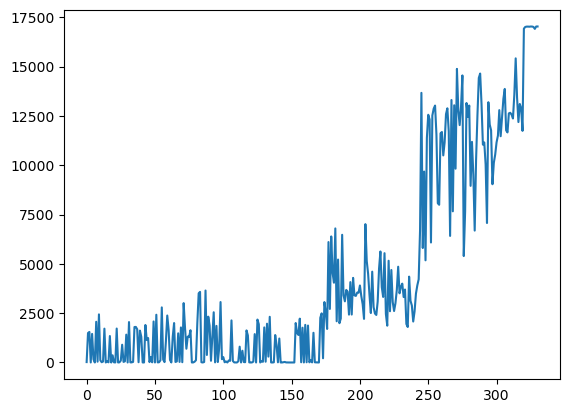

In [15]:
import matplotlib.pyplot as plt
zeros = [len(column_data[column_data == -1]) for _, column_data in result_df.iteritems()]
plt.plot(zeros)
plt.show()

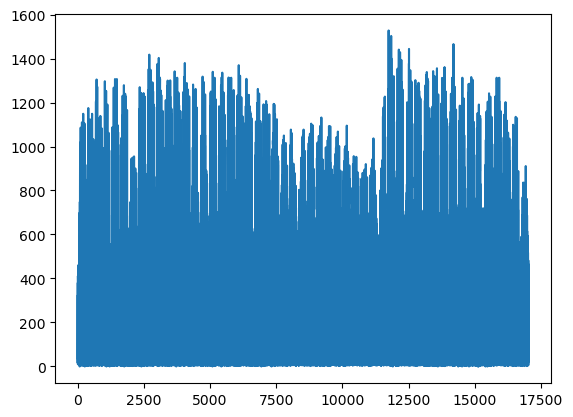

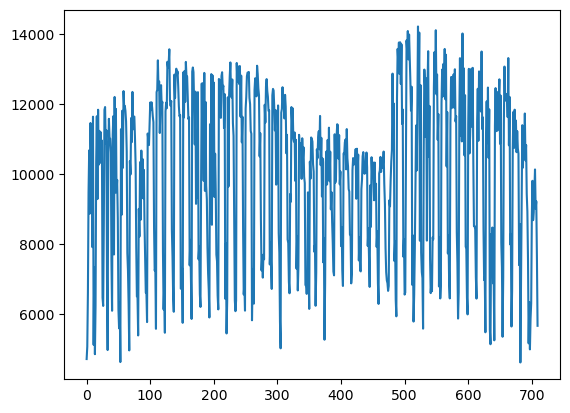

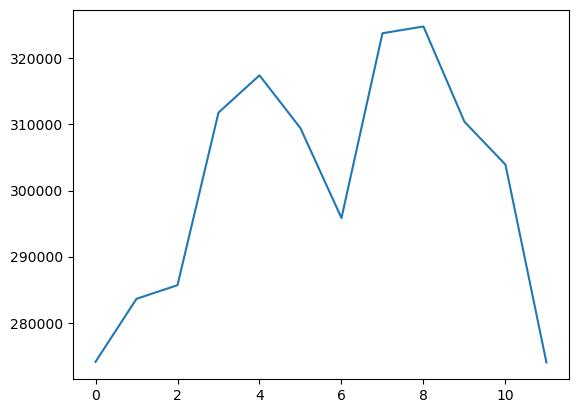

In [61]:
data_hourly = data[:, 0]
data_daily = data_hourly.reshape(-1, 24).sum(axis=1)
data_monthly = data_daily[:360].reshape(-1, 30).sum(axis=1)
plt.plot(data_hourly)
plt.show()
plt.plot(data_daily)
plt.show()
plt.plot(data_monthly)
plt.show()

## 坐标信息

同一 route_id 下还会因 route_dir 的不同而有多行数据，因此需要将其重心取平均值作为最终 route_id 的坐标


In [62]:
gdf = gpd.read_file(r'shp\bus_routes_nyc_dec2019.shp').to_crs(epsg=4326)
gdf['centroid'] = gdf['geometry'].centroid

df = pd.read_csv('pre2_data.csv')
target_route_id = df.columns
given_route_id = gdf['route_id'].unique()

stationInfoList = []
stationsList = gpd.GeoDataFrame()
for route in tqdm(target_route_id):
    if route not in given_route_id:
        df.drop(columns=[route], inplace=True)
        continue
    stations = gdf[gdf['route_id'] == route]
    # [id, build-time, lat, lng, name]
    stationInfo = [
        route, 
        '2022-2-1', 
        stations['centroid'].y.mean(), 
        stations['centroid'].x.mean(), 
        stations['route_long'].unique()[0]
    ]
    stationInfoList.append(stationInfo)
    stationsList = stationsList.append(stations)

print(df)
print(stationInfoList)

f:\miniconda3\envs\UCTB\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
100%|██████████| 332/332 [00:01<00:00, 239.74it/s]

        B1  B103  B11  B12  B13  B14  B15  B16  B17  B24  ...  BX20  Q42  S56  \
0        9    42    8   33   16   10   97    6   24    4  ...    -1   -1   -1   
1        3    13    1   12    2    8   35   -1   10   -1  ...    -1   -1   -1   
2        3     2   -1   12   -1    1   52   -1    4   -1  ...    -1   -1   -1   
3        3    -1   -1    7   -1    3   57   -1   12   -1  ...    -1   -1   -1   
4       13    -1   16   46    9    4  164   -1    8   -1  ...    -1   -1   -1   
...    ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...  ...   
17035  300   198  110  142   83   59  181   68  177   58  ...     6    8   -1   
17036  202   133   78   85   70   42  163   19  117   25  ...    -1   -1   -1   
17037  125    86   33   40   47   31   90   27   60   13  ...    -1   -1   -1   
17038   60    48   19   41   15   17   78   16   52   10  ...    -1   -1   -1   
17039   28    30    4   21   21    8   49    8   18   11  ...    -1   -1   -1   

       Q26  S84  S89  S86  

最终只剩下226个 route_id 是有效的

f:\miniconda3\envs\UCTB\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

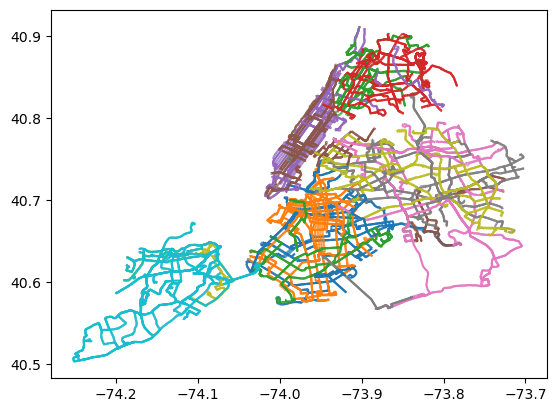

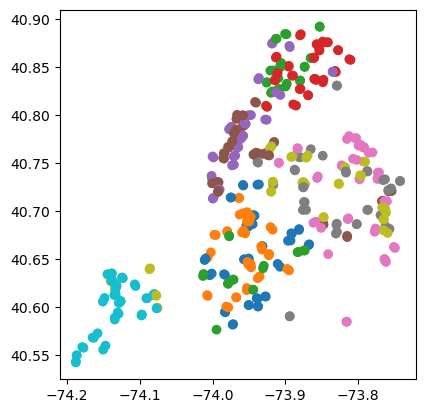

In [63]:
stationsList.plot('route_id')
stationsList.set_geometry('centroid').plot('route_id')

## 保存数据

In [64]:
# Save data as CSV
df.to_csv('data_with_station.csv', index=False)
# Save data as pickle
DataFormat = {
    "TimeRange": ['2022-2-1', '2024-1-13'],    # 起止时间 str eg:['2016-10-01', '2016-11-30']
    "TimeFitness": 60,  # 时间粒度 int 单位为min
    "Node": {
        "TrafficNode": df.values,  # np.array, with shape [time_slots, num-of-node] eg:(1440,256) 
        "TrafficMonthlyInteraction": [], # np.array, With shape [month, num-of-node. num-of-node]
        "StationInfo": stationsList,  # list of [id, build-time, lat, lng, name], eg:['0', 0, 34.210542575000005, 108.91390095, 'grid_0']
        "POI": []
    },
    "Grid": {
        "TrafficGrid": [], # with shape [slots, num-of-node. num-of-node] eg:(120, 256, 256)
        "GridLatLng": [],  # 对角线点的经纬度 eg:[[34.20829427, 108.91118]]
        "POI": []
    },
    "ExternalFeature": {
        "Weather": []
    }
}

with open('data_with_station.pkl', 'wb') as f:
    pickle.dump(DataFormat, f)